# 1: SETUP & DATA LOADING

In [1]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import chi2_contingency, skew, kurtosis

# Visualization settings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("="*80)
print("COMPREHENSIVE EDA FOR LOAN DEFAULT PREDICTION")
print("="*80)
print("\n✓ Libraries imported successfully")
print("✓ Visualization settings configured")
print("✓ Ready to load data...")

COMPREHENSIVE EDA FOR LOAN DEFAULT PREDICTION

✓ Libraries imported successfully
✓ Visualization settings configured
✓ Ready to load data...


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

print("\n" + "="*80)
print("DATA LOADING SUMMARY")
print("="*80)
print(f"✓ Training set loaded: {train_df.shape[0]:,} rows × {train_df.shape[1]} columns")
print(f"✓ Test set loaded: {test_df.shape[0]:,} rows × {test_df.shape[1]} columns")
print(f"✓ Sample submission loaded: {sample_submission.shape[0]:,} rows × {sample_submission.shape[1]} columns")
print("\n📊 This is a {'BALANCED' if train_df['loan_paid_back'].mean() > 0.4 and train_df['loan_paid_back'].mean() < 0.6 else 'IMBALANCED'} classification problem")
print(f"   Target distribution: {train_df['loan_paid_back'].value_counts().to_dict()}")


DATA LOADING SUMMARY
✓ Training set loaded: 593,994 rows × 13 columns
✓ Test set loaded: 254,569 rows × 12 columns
✓ Sample submission loaded: 254,569 rows × 2 columns

📊 This is a {'BALANCED' if train_df['loan_paid_back'].mean() > 0.4 and train_df['loan_paid_back'].mean() < 0.6 else 'IMBALANCED'} classification problem
   Target distribution: {1.0: 474494, 0.0: 119500}


# 2: INITIAL DATA INSPECTION

In [3]:
print("\n" + "="*80)
print("SECTION 1: DATASET STRUCTURE & OVERVIEW")
print("="*80)

# Basic information
print("\n📋 TRAINING DATA INFO:")
print("-"*80)
print(train_df.info())

print("\n" + "-"*80)
print("📊 FIRST FEW ROWS:")
print("-"*80)
print(train_df.head(10))

print("\n" + "-"*80)
print("📈 STATISTICAL SUMMARY:")
print("-"*80)
print(train_df.describe())

# Data types summary
print("\n" + "-"*80)
print("🔢 DATA TYPES SUMMARY:")
print("-"*80)
dtype_summary = train_df.dtypes.value_counts()
print(dtype_summary)
print(f"\nNumerical columns: {len(train_df.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical columns: {len(train_df.select_dtypes(include=['object']).columns)}")

# Column names and types
print("\n" + "-"*80)
print("📝 COLUMN INVENTORY:")
print("-"*80)
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical Features ({len(numerical_cols)}):")
for col in numerical_cols:
    print(f"  • {col}")

print(f"\nCategorical Features ({len(categorical_cols)}):")
for col in categorical_cols:
    print(f"  • {col}")

# Memory usage
print("\n" + "-"*80)
print("💾 MEMORY USAGE:")
print("-"*80)
memory_usage = train_df.memory_usage(deep=True).sum() / 1024**2
print(f"Total memory usage: {memory_usage:.2f} MB")
print("\nMemory usage by column:")
mem_by_col = train_df.memory_usage(deep=True).sort_values(ascending=False)
for col, mem in mem_by_col.head(10).items():
    print(f"  • {col}: {mem/1024:.2f} KB")


SECTION 1: DATASET STRUCTURE & OVERVIEW

📋 TRAINING DATA INFO:
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_b

# 3: MISSING VALUES ANALYSIS

In [4]:
print("\n" + "="*80)
print("SECTION 2: DATA QUALITY - MISSING VALUES")
print("="*80)

# Calculate missing values
missing_train = pd.DataFrame({
    'Column': train_df.columns,
    'Missing_Count': train_df.isnull().sum(),
    'Missing_Percentage': (train_df.isnull().sum() / len(train_df)) * 100,
    'Data_Type': train_df.dtypes
})
missing_train = missing_train[missing_train['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print("\n🔍 MISSING VALUES SUMMARY (TRAINING SET):")
print("-"*80)
if len(missing_train) == 0:
    print("✓ NO MISSING VALUES FOUND - Dataset is complete!")
else:
    print(missing_train.to_string(index=False))
    print(f"\n📊 Total columns with missing values: {len(missing_train)}")
    print(f"📊 Total missing cells: {missing_train['Missing_Count'].sum():,}")

# Missing values in test set
missing_test = pd.DataFrame({
    'Column': test_df.columns,
    'Missing_Count': test_df.isnull().sum(),
    'Missing_Percentage': (test_df.isnull().sum() / len(test_df)) * 100,
    'Data_Type': test_df.dtypes
})
missing_test = missing_test[missing_test['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print("\n🔍 MISSING VALUES SUMMARY (TEST SET):")
print("-"*80)
if len(missing_test) == 0:
    print("✓ NO MISSING VALUES FOUND in test set!")
else:
    print(missing_test.to_string(index=False))

# Visualize missing values if any exist
if len(missing_train) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Missing values bar plot
    ax1 = axes[0]
    missing_train.sort_values('Missing_Percentage').plot(
        x='Column', y='Missing_Percentage', kind='barh', ax=ax1, color='coral'
    )
    ax1.set_title('Missing Values Percentage by Column', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Missing Percentage (%)', fontsize=12)
    ax1.set_ylabel('Columns', fontsize=12)
    ax1.grid(axis='x', alpha=0.3)
    
    # Missing values heatmap
    ax2 = axes[1]
    missing_matrix = train_df[missing_train['Column'].tolist()].isnull().T
    sns.heatmap(missing_matrix.iloc[:, :100], cmap='RdYlGn_r', cbar=True, 
                ax=ax2, yticklabels=True, xticklabels=False)
    ax2.set_title('Missing Values Pattern (First 100 rows)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Row Index', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Check for patterns in missing values
    print("\n" + "-"*80)
    print("🔗 MISSING VALUE PATTERNS:")
    print("-"*80)
    missing_cols = missing_train['Column'].tolist()
    if len(missing_cols) >= 2:
        print("\nChecking correlation between missing values...")
        missing_corr = train_df[missing_cols].isnull().astype(int).corr()
        print("\nTop correlated missing patterns:")
        
        # Get upper triangle of correlation matrix
        mask = np.triu(np.ones_like(missing_corr), k=1).astype(bool)
        missing_corr_flat = missing_corr.where(mask).stack().sort_values(ascending=False)
        
        if len(missing_corr_flat) > 0:
            print(missing_corr_flat.head(10))
        else:
            print("No significant patterns found")


SECTION 2: DATA QUALITY - MISSING VALUES

🔍 MISSING VALUES SUMMARY (TRAINING SET):
--------------------------------------------------------------------------------
✓ NO MISSING VALUES FOUND - Dataset is complete!

🔍 MISSING VALUES SUMMARY (TEST SET):
--------------------------------------------------------------------------------
✓ NO MISSING VALUES FOUND in test set!


# 4: DUPLICATE ANALYSIS & ID COLUMNS

In [5]:
print("\n" + "="*80)
print("SECTION 3: DATA QUALITY - DUPLICATES & IDENTIFIERS")
print("="*80)

# Check for duplicates
print("\n🔍 DUPLICATE ROWS ANALYSIS:")
print("-"*80)
train_duplicates = train_df.duplicated().sum()
test_duplicates = test_df.duplicated().sum()

print(f"Training set duplicates: {train_duplicates:,} ({train_duplicates/len(train_df)*100:.2f}%)")
print(f"Test set duplicates: {test_duplicates:,} ({test_duplicates/len(test_df)*100:.2f}%)")

if train_duplicates > 0:
    print("\n⚠️ Duplicate rows found! Showing first 5 duplicate examples:")
    duplicate_mask = train_df.duplicated(keep=False)
    print(train_df[duplicate_mask].head(10))

# Check ID column
print("\n" + "-"*80)
print("🆔 ID COLUMN ANALYSIS:")
print("-"*80)

id_col = 'id' if 'id' in train_df.columns else train_df.columns[0]
print(f"Identified ID column: '{id_col}'")

train_id_unique = train_df[id_col].nunique()
test_id_unique = test_df[id_col].nunique()

print(f"\nTraining set:")
print(f"  • Total rows: {len(train_df):,}")
print(f"  • Unique IDs: {train_id_unique:,}")
print(f"  • Duplicated IDs: {len(train_df) - train_id_unique:,}")
print(f"  • ✓ ID uniqueness: {'PASS' if train_id_unique == len(train_df) else 'FAIL'}")

print(f"\nTest set:")
print(f"  • Total rows: {len(test_df):,}")
print(f"  • Unique IDs: {test_id_unique:,}")
print(f"  • Duplicated IDs: {len(test_df) - test_id_unique:,}")
print(f"  • ✓ ID uniqueness: {'PASS' if test_id_unique == len(test_df) else 'FAIL'}")

# Check for ID overlap
print(f"\n🔄 ID OVERLAP CHECK:")
print("-"*80)
id_overlap = set(train_df[id_col]) & set(test_df[id_col])
print(f"Common IDs between train and test: {len(id_overlap):,}")
if len(id_overlap) > 0:
    print(f"⚠️ WARNING: Data leakage risk! {len(id_overlap)} IDs appear in both sets")
    print(f"Sample overlapping IDs: {list(id_overlap)[:5]}")
else:
    print("✓ No overlap - Good data split!")

# Check for constant columns
print("\n" + "-"*80)
print("📊 CONSTANT & LOW-VARIANCE COLUMNS:")
print("-"*80)
constant_cols = []
low_variance_cols = []

for col in train_df.columns:
    unique_count = train_df[col].nunique()
    if unique_count == 1:
        constant_cols.append(col)
    elif unique_count == 2 and col != 'loan_paid':  # Binary but not target
        low_variance_cols.append((col, unique_count))
        
print(f"Constant columns (only 1 unique value): {len(constant_cols)}")
if constant_cols:
    print(f"  {constant_cols}")
    
print(f"\nBinary columns (2 unique values): {len(low_variance_cols)}")
if low_variance_cols:
    for col, count in low_variance_cols[:10]:
        print(f"  • {col}: {count} unique values")


SECTION 3: DATA QUALITY - DUPLICATES & IDENTIFIERS

🔍 DUPLICATE ROWS ANALYSIS:
--------------------------------------------------------------------------------
Training set duplicates: 0 (0.00%)
Test set duplicates: 0 (0.00%)

--------------------------------------------------------------------------------
🆔 ID COLUMN ANALYSIS:
--------------------------------------------------------------------------------
Identified ID column: 'id'

Training set:
  • Total rows: 593,994
  • Unique IDs: 593,994
  • Duplicated IDs: 0
  • ✓ ID uniqueness: PASS

Test set:
  • Total rows: 254,569
  • Unique IDs: 254,569
  • Duplicated IDs: 0
  • ✓ ID uniqueness: PASS

🔄 ID OVERLAP CHECK:
--------------------------------------------------------------------------------
Common IDs between train and test: 0
✓ No overlap - Good data split!

--------------------------------------------------------------------------------
📊 CONSTANT & LOW-VARIANCE COLUMNS:
-------------------------------------------------------

# 5: TARGET VARIABLE ANALYSIS


SECTION 4: TARGET VARIABLE DEEP DIVE

🎯 TARGET VARIABLE STATISTICS:
--------------------------------------------------------------------------------
Column name: 'loan_paid_back'
Data type: float64

Value Counts:
loan_paid_back
0.000    119500
1.000    474494
Name: count, dtype: int64

Percentage Distribution:
  Class 0.0: 20.12%
  Class 1.0: 79.88%

--------------------------------------------------------------------------------
⚖️ CLASS BALANCE ANALYSIS:
--------------------------------------------------------------------------------
Majority class size: 474,494
Minority class size: 119,500
Imbalance ratio: 3.97:1
⚠️ HIGHLY IMBALANCED dataset detected!
   Consider using: SMOTE, class weights, or stratified sampling


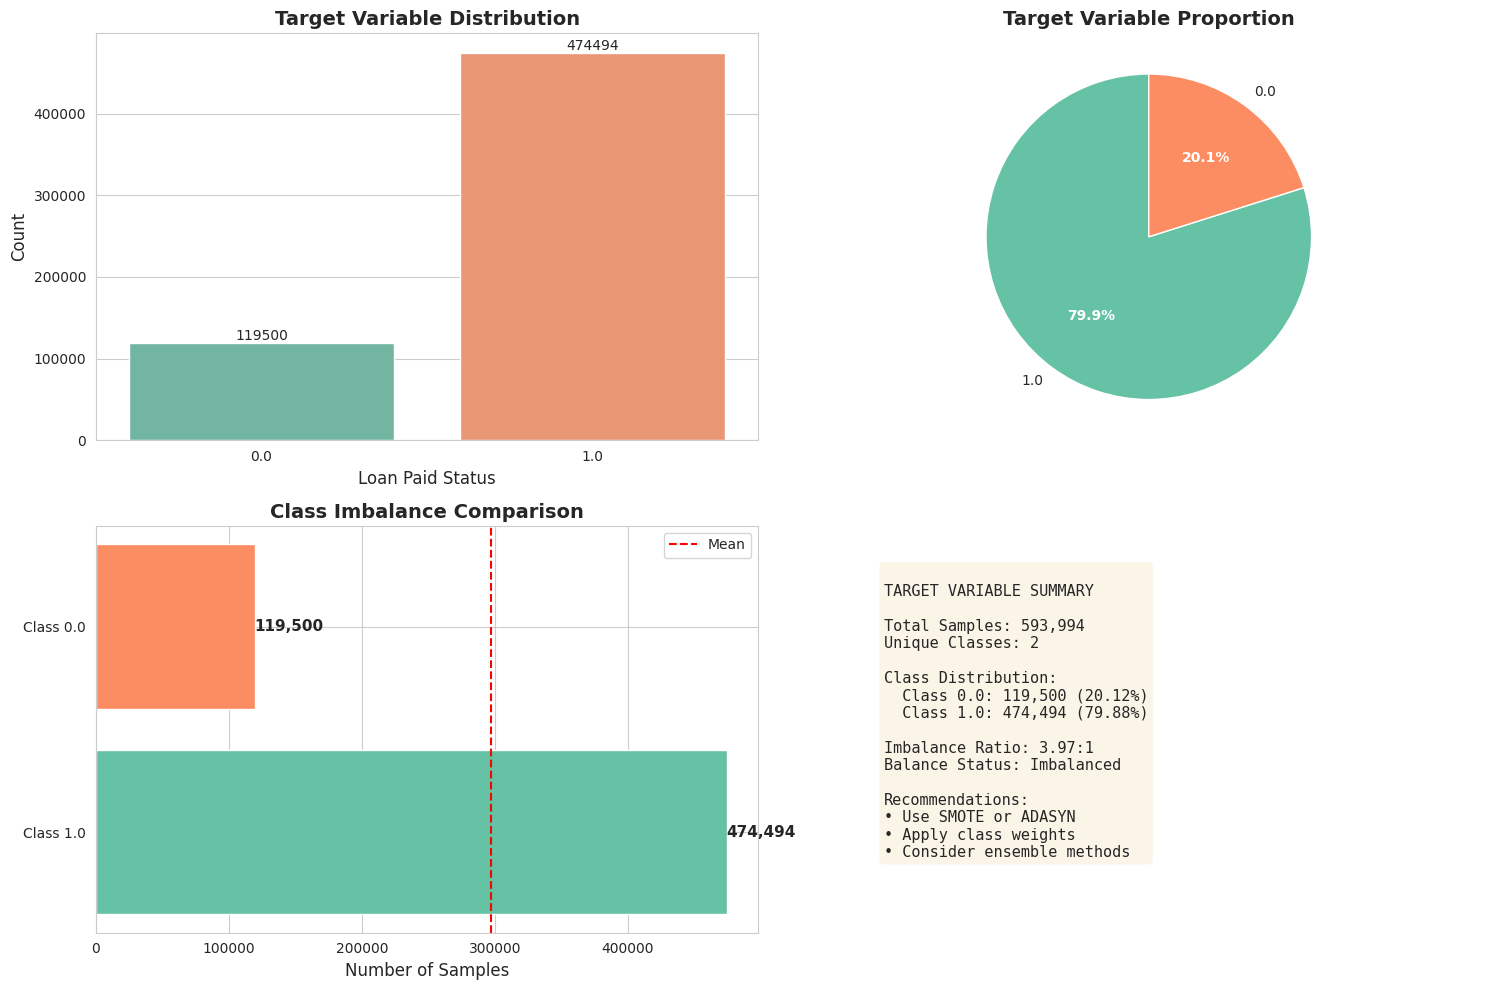


✓ Target variable analysis complete


In [6]:
print("\n" + "="*80)
print("SECTION 4: TARGET VARIABLE DEEP DIVE")
print("="*80)

target_col = 'loan_paid_back'

# Basic statistics
print("\n🎯 TARGET VARIABLE STATISTICS:")
print("-"*80)
print(f"Column name: '{target_col}'")
print(f"Data type: {train_df[target_col].dtype}")
print(f"\nValue Counts:")
print(train_df[target_col].value_counts().sort_index())

print(f"\nPercentage Distribution:")
target_dist = train_df[target_col].value_counts(normalize=True) * 100
for value, pct in target_dist.sort_index().items():
    print(f"  Class {value}: {pct:.2f}%")

# Class balance analysis
print("\n" + "-"*80)
print("⚖️ CLASS BALANCE ANALYSIS:")
print("-"*80)
class_counts = train_df[target_col].value_counts()
majority_class = class_counts.max()
minority_class = class_counts.min()
imbalance_ratio = majority_class / minority_class

print(f"Majority class size: {majority_class:,}")
print(f"Minority class size: {minority_class:,}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print(f"⚠️ HIGHLY IMBALANCED dataset detected!")
    print(f"   Consider using: SMOTE, class weights, or stratified sampling")
elif imbalance_ratio > 1.5:
    print(f"⚠️ MODERATELY IMBALANCED dataset")
    print(f"   Consider using: stratified cross-validation, class weights")
else:
    print(f"✓ BALANCED dataset - standard methods should work well")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Count plot
ax1 = axes[0, 0]
sns.countplot(data=train_df, x=target_col, ax=ax1, palette='Set2')
ax1.set_title('Target Variable Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Loan Paid Status', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d')

# 2. Pie chart
ax2 = axes[0, 1]
colors = sns.color_palette('Set2')[0:len(class_counts)]
wedges, texts, autotexts = ax2.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%',
                                     colors=colors, startangle=90)
ax2.set_title('Target Variable Proportion', fontsize=14, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# 3. Imbalance visualization
ax3 = axes[1, 0]
class_names = [f'Class {i}' for i in class_counts.index]
bars = ax3.barh(class_names, class_counts.values, color=colors)
ax3.set_title('Class Imbalance Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Number of Samples', fontsize=12)
ax3.axvline(x=class_counts.mean(), color='red', linestyle='--', label='Mean')
ax3.legend()
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontsize=11, fontweight='bold')

# 4. Statistical summary
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
TARGET VARIABLE SUMMARY

Total Samples: {len(train_df):,}
Unique Classes: {train_df[target_col].nunique()}

Class Distribution:
"""
for cls in sorted(train_df[target_col].unique()):
    count = (train_df[target_col] == cls).sum()
    pct = count / len(train_df) * 100
    summary_text += f"  Class {cls}: {count:,} ({pct:.2f}%)\n"

summary_text += f"""
Imbalance Ratio: {imbalance_ratio:.2f}:1
Balance Status: {'Imbalanced' if imbalance_ratio > 1.5 else 'Balanced'}

Recommendations:
"""
if imbalance_ratio > 3:
    summary_text += "• Use SMOTE or ADASYN\n• Apply class weights\n• Consider ensemble methods"
elif imbalance_ratio > 1.5:
    summary_text += "• Use stratified CV\n• Apply class weights\n• Monitor precision/recall"
else:
    summary_text += "• Standard methods OK\n• Use accuracy metric\n• Simple train/val split"

ax4.text(0.1, 0.9, summary_text, transform=ax4.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n✓ Target variable analysis complete")

# 6: NUMERICAL FEATURES ANALYSIS


SECTION 5: NUMERICAL FEATURES DEEP DIVE

📊 Analyzing 5 numerical features...
--------------------------------------------------------------------------------

📈 NUMERICAL FEATURES STATISTICS:
             Feature  Count  Missing      Mean    Median       Std      Min        Max  Skewness  Kurtosis  Zeros  Zeros_%  Unique
       annual_income 593994        0 48212.203 46557.680 26711.942 6002.430 393381.740     1.720     7.091      0    0.000  119728
debt_to_income_ratio 593994        0     0.121     0.096     0.069    0.011      0.627     1.407     2.335      0    0.000     526
        credit_score 593994        0   680.916   682.000    55.425  395.000    849.000    -0.167     0.096      0    0.000     399
         loan_amount 593994        0 15020.298 15000.220  6926.531  500.090  48959.950     0.207    -0.150      0    0.000  111570
       interest_rate 593994        0    12.356    12.370     2.009    3.200     20.990     0.050     0.060      0    0.000    1454

--------------------

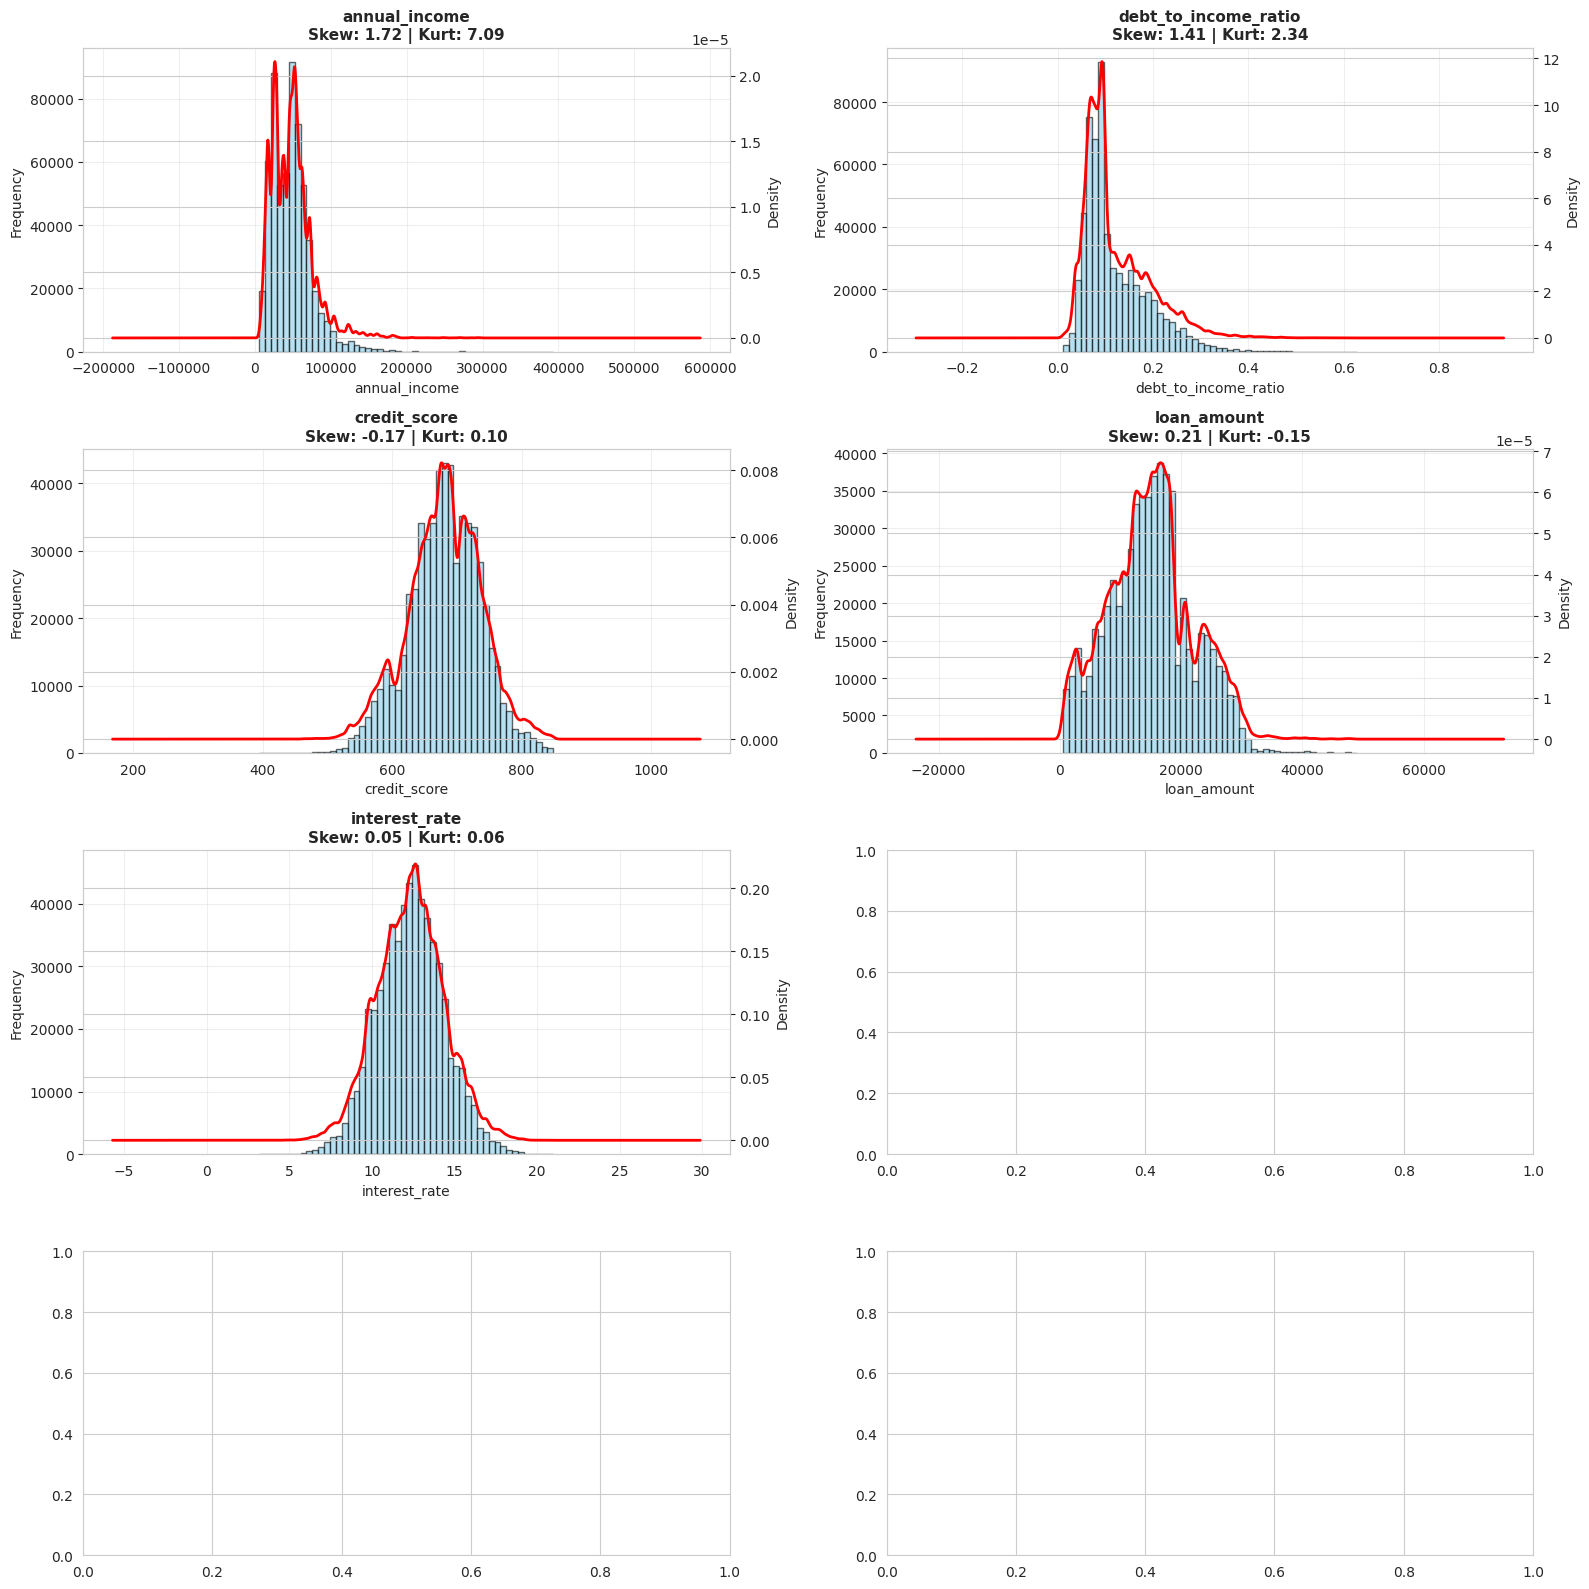


📦 Generating box plots for outlier detection...


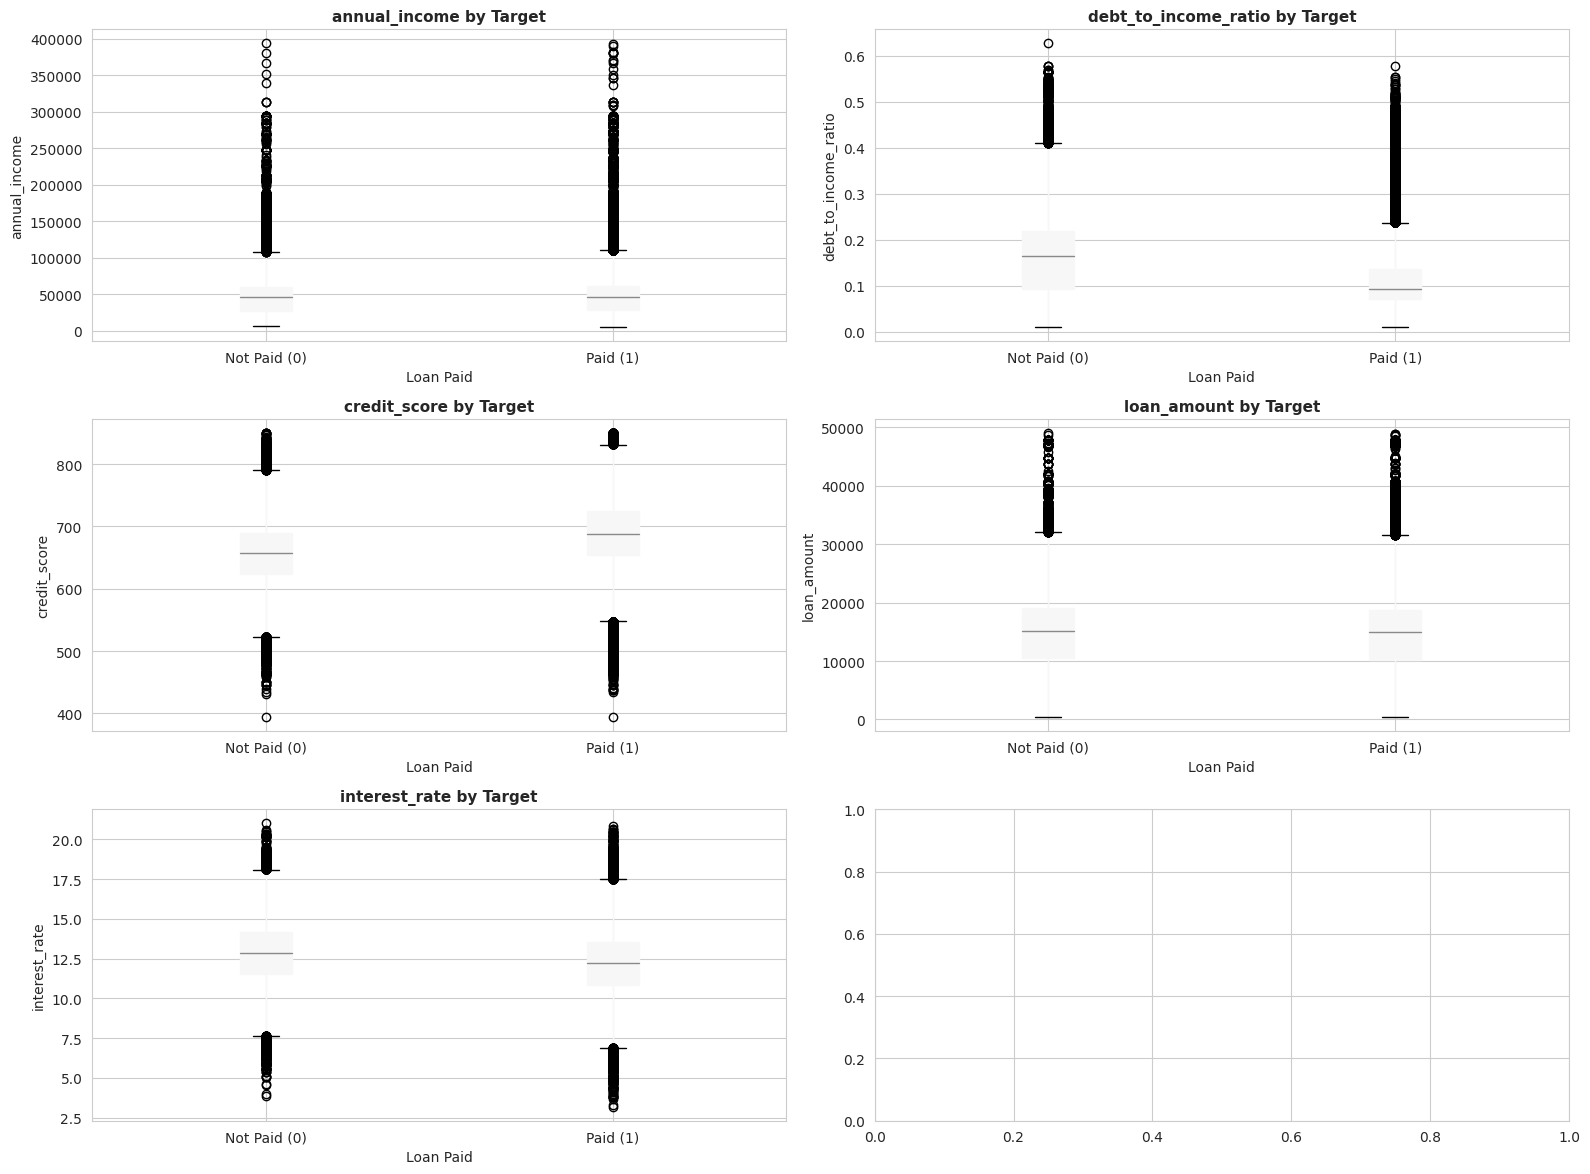


--------------------------------------------------------------------------------
🎯 OUTLIER DETECTION (IQR Method):
--------------------------------------------------------------------------------
             Feature  Outlier_Count  Outlier_%  Lower_Bound  Upper_Bound
debt_to_income_ratio          17556      2.956       -0.054        0.282
       annual_income          15917      2.680   -21635.980   110551.700
        credit_score           5901      0.993      536.500      828.500
       interest_rate           5136      0.865        6.955       17.715
         loan_amount           2902      0.489    -2588.820    31727.020

✓ Numerical features analysis complete


In [7]:
print("\n" + "="*80)
print("SECTION 5: NUMERICAL FEATURES DEEP DIVE")
print("="*80)

# Get numerical columns (excluding ID and target)
numerical_features = [col for col in train_df.select_dtypes(include=[np.number]).columns 
                     if col not in ['id', 'loan_paid_back']]

print(f"\n📊 Analyzing {len(numerical_features)} numerical features...")
print("-"*80)

# Detailed statistics for each numerical feature
num_stats = pd.DataFrame()
for col in numerical_features:
    stats_dict = {
        'Feature': col,
        'Count': train_df[col].count(),
        'Missing': train_df[col].isnull().sum(),
        'Mean': train_df[col].mean(),
        'Median': train_df[col].median(),
        'Std': train_df[col].std(),
        'Min': train_df[col].min(),
        'Max': train_df[col].max(),
        'Skewness': skew(train_df[col].dropna()),
        'Kurtosis': kurtosis(train_df[col].dropna()),
        'Zeros': (train_df[col] == 0).sum(),
        'Zeros_%': (train_df[col] == 0).sum() / len(train_df) * 100,
        'Unique': train_df[col].nunique(),
    }
    num_stats = pd.concat([num_stats, pd.DataFrame([stats_dict])], ignore_index=True)

print("\n📈 NUMERICAL FEATURES STATISTICS:")
print(num_stats.to_string(index=False))

# Identify features with specific characteristics
print("\n" + "-"*80)
print("🔍 FEATURE CHARACTERISTICS:")
print("-"*80)

highly_skewed = num_stats[abs(num_stats['Skewness']) > 2]['Feature'].tolist()
high_zeros = num_stats[num_stats['Zeros_%'] > 50]['Feature'].tolist()
low_variance = num_stats[num_stats['Std'] / (num_stats['Mean'] + 1e-10) < 0.01]['Feature'].tolist()

print(f"\nHighly skewed features (|skew| > 2): {len(highly_skewed)}")
if highly_skewed:
    print(f"  {highly_skewed}")
    
print(f"\nFeatures with >50% zeros: {len(high_zeros)}")
if high_zeros:
    print(f"  {high_zeros}")
    
print(f"\nLow variance features: {len(low_variance)}")
if low_variance:
    print(f"  {low_variance}")

# Distribution plots for key numerical features
print("\n📊 Generating distribution plots for top features...")
n_features_to_plot = min(8, len(numerical_features))
features_to_plot = numerical_features[:n_features_to_plot]

fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.ravel()

for idx, col in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Histogram with KDE
    train_df[col].hist(bins=50, ax=ax, alpha=0.6, color='skyblue', edgecolor='black')
    ax2 = ax.twinx()
    train_df[col].plot(kind='kde', ax=ax2, color='red', linewidth=2)
    
    ax.set_title(f'{col}\nSkew: {skew(train_df[col].dropna()):.2f} | '
                 f'Kurt: {kurtosis(train_df[col].dropna()):.2f}',
                 fontsize=11, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax2.set_ylabel('Density', fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Box plots to identify outliers
print("\n📦 Generating box plots for outlier detection...")
fig, axes = plt.subplots((n_features_to_plot + 1) // 2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, col in enumerate(features_to_plot):
    ax = axes[idx]
    
    # Box plot by target
    train_df.boxplot(column=col, by='loan_paid_back', ax=ax, patch_artist=True)
    ax.set_title(f'{col} by Target', fontsize=11, fontweight='bold')
    ax.set_xlabel('Loan Paid', fontsize=10)
    ax.set_ylabel(col, fontsize=10)
    plt.sca(ax)
    plt.xticks([1, 2], ['Not Paid (0)', 'Paid (1)'])

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

# Outlier detection
print("\n" + "-"*80)
print("🎯 OUTLIER DETECTION (IQR Method):")
print("-"*80)

outlier_summary = []
for col in numerical_features:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = train_df[(train_df[col] < lower_bound) | (train_df[col] > upper_bound)][col]
    outlier_count = len(outliers)
    outlier_pct = outlier_count / len(train_df) * 100
    
    if outlier_count > 0:
        outlier_summary.append({
            'Feature': col,
            'Outlier_Count': outlier_count,
            'Outlier_%': outlier_pct,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outlier_%', ascending=False)
if len(outlier_df) > 0:
    print(outlier_df.to_string(index=False))
else:
    print("✓ No outliers detected in numerical features")

print("\n✓ Numerical features analysis complete")

# 7: CATEGORICAL FEATURES ANALYSIS


SECTION 6: CATEGORICAL FEATURES DEEP DIVE

📊 Analyzing 6 categorical features...
--------------------------------------------------------------------------------

📋 CATEGORICAL FEATURES STATISTICS:
          Feature  Unique_Values  Missing  Missing_%      Most_Frequent  Most_Freq_Count  Most_Freq_%
           gender              3        0      0.000             Female           306175       51.545
   marital_status              4        0      0.000             Single           288843       48.627
  education_level              5        0      0.000         Bachelor's           279606       47.072
employment_status              5        0      0.000           Employed           450645       75.867
     loan_purpose              8        0      0.000 Debt consolidation           324695       54.663
   grade_subgrade             30        0      0.000                 C3            58695        9.881

--------------------------------------------------------------------------------
🔍 CAR

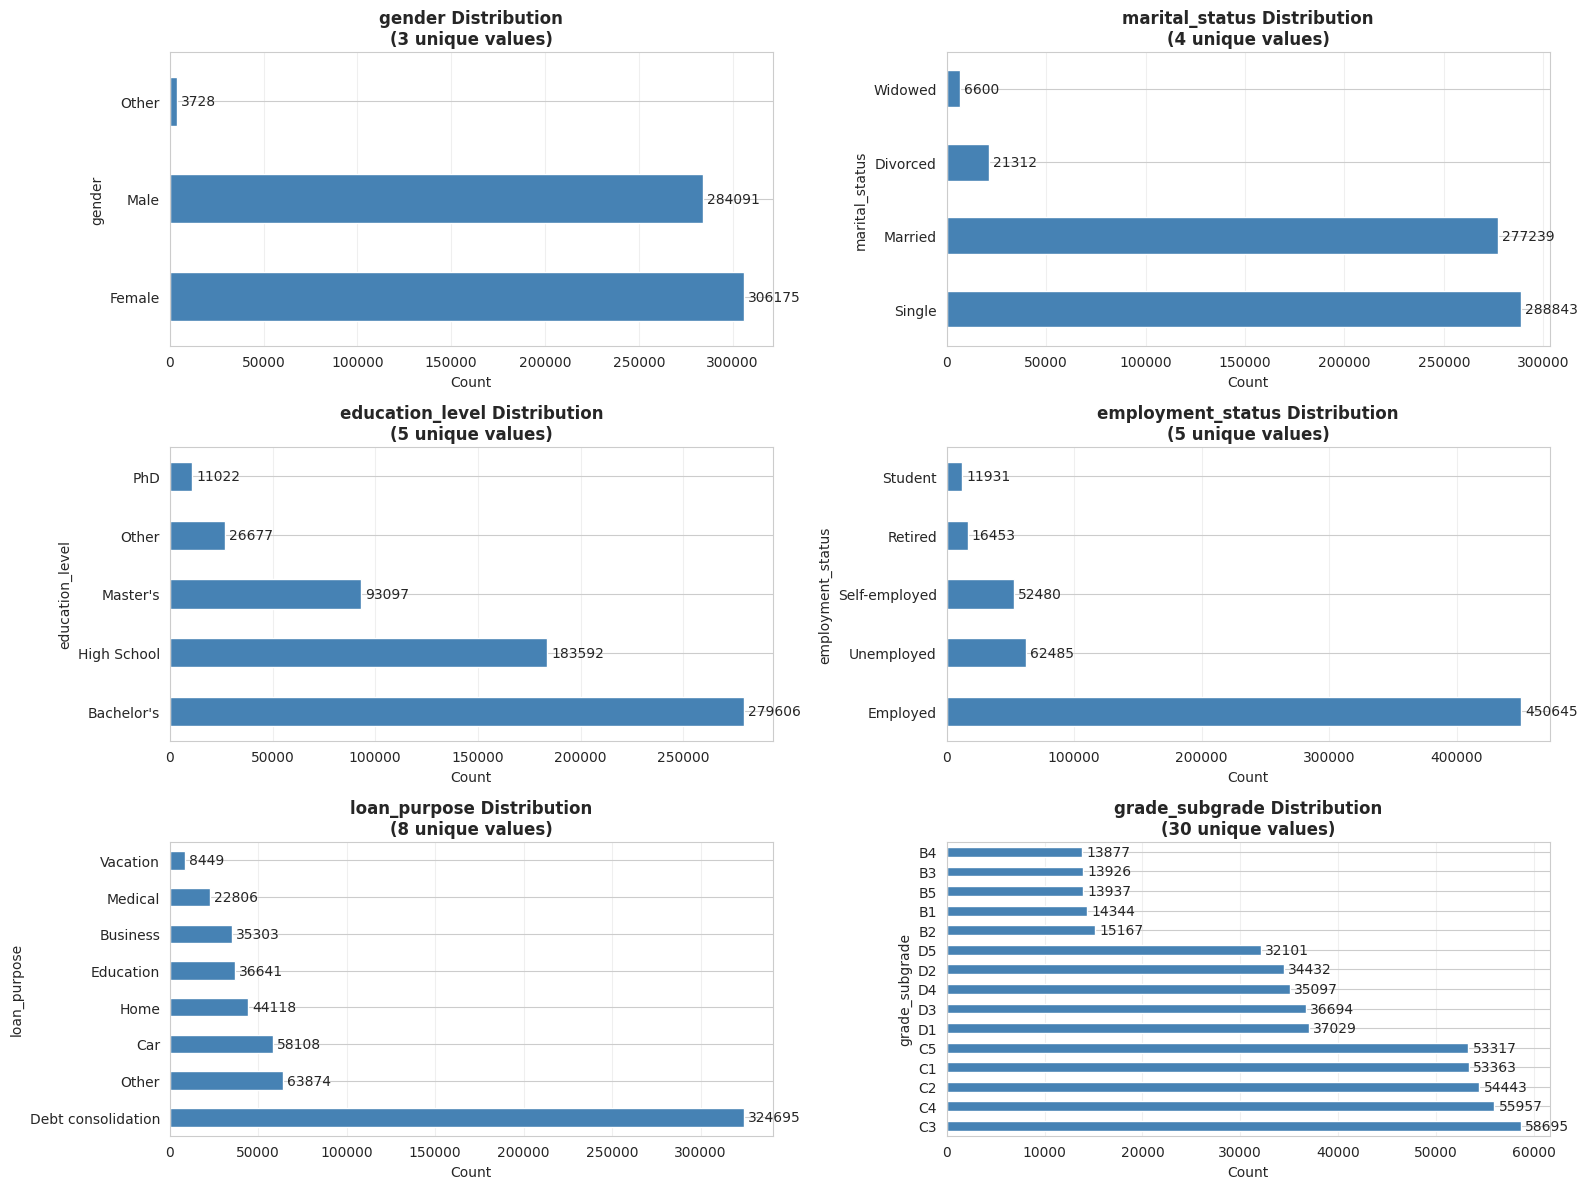


📊 Generating target relationship plots...


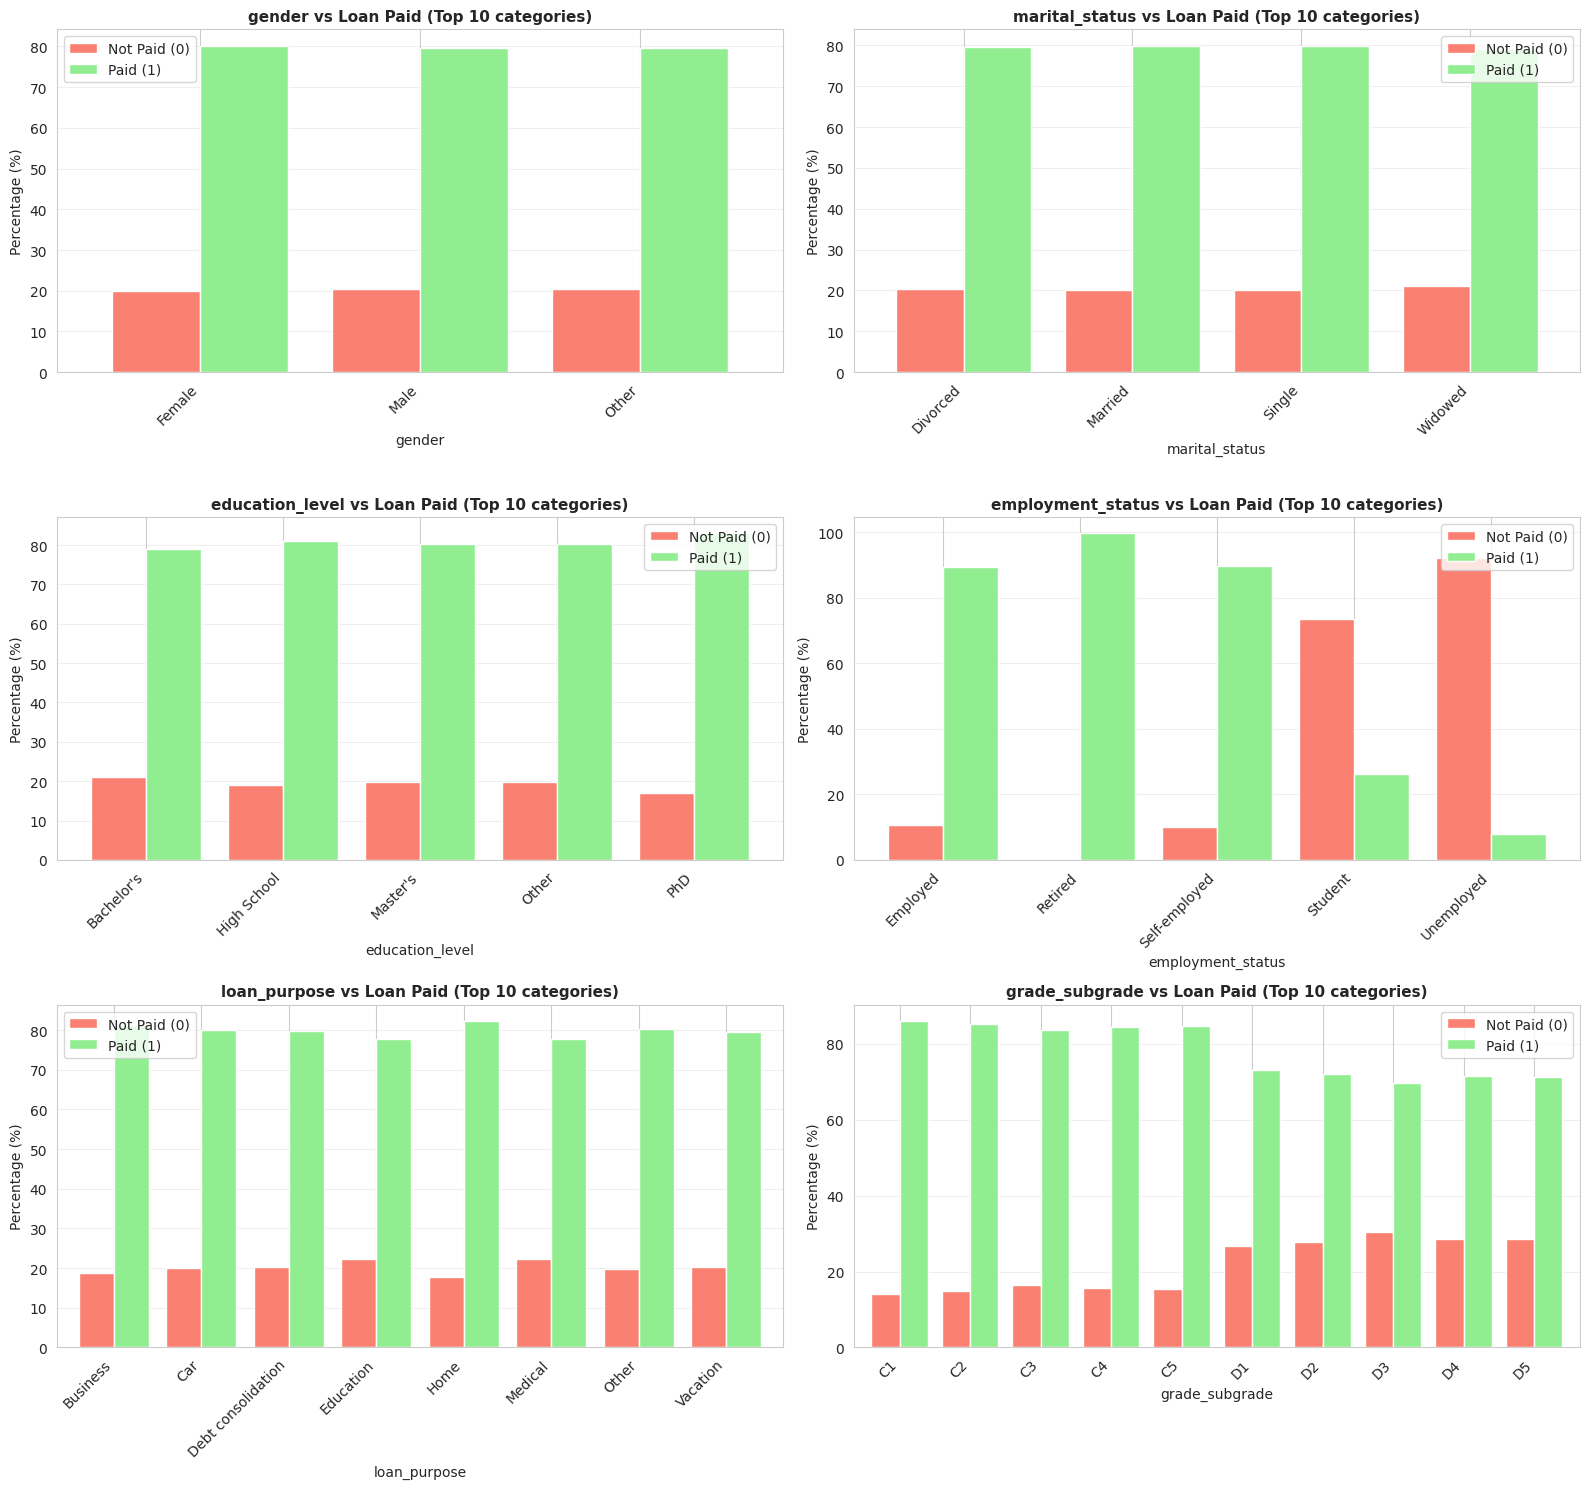


✓ Categorical features analysis complete


In [8]:
print("\n" + "="*80)
print("SECTION 6: CATEGORICAL FEATURES DEEP DIVE")
print("="*80)

# Get categorical columns (excluding ID)
categorical_features = [col for col in train_df.select_dtypes(include=['object']).columns 
                       if col != 'id']

print(f"\n📊 Analyzing {len(categorical_features)} categorical features...")
print("-"*80)

# Detailed statistics for each categorical feature
cat_stats = pd.DataFrame()
for col in categorical_features:
    stats_dict = {
        'Feature': col,
        'Unique_Values': train_df[col].nunique(),
        'Missing': train_df[col].isnull().sum(),
        'Missing_%': train_df[col].isnull().sum() / len(train_df) * 100,
        'Most_Frequent': train_df[col].mode()[0] if len(train_df[col].mode()) > 0 else None,
        'Most_Freq_Count': train_df[col].value_counts().iloc[0] if len(train_df[col]) > 0 else 0,
        'Most_Freq_%': train_df[col].value_counts(normalize=True).iloc[0] * 100 if len(train_df[col]) > 0 else 0,
    }
    cat_stats = pd.concat([cat_stats, pd.DataFrame([stats_dict])], ignore_index=True)

print("\n📋 CATEGORICAL FEATURES STATISTICS:")
print(cat_stats.to_string(index=False))

# Identify high and low cardinality features
print("\n" + "-"*80)
print("🔍 CARDINALITY ANALYSIS:")
print("-"*80)

high_cardinality = cat_stats[cat_stats['Unique_Values'] > 10]['Feature'].tolist()
low_cardinality = cat_stats[cat_stats['Unique_Values'] <= 5]['Feature'].tolist()
binary_features = cat_stats[cat_stats['Unique_Values'] == 2]['Feature'].tolist()

print(f"\nHigh cardinality features (>10 unique): {len(high_cardinality)}")
if high_cardinality:
    for feat in high_cardinality:
        unique_count = train_df[feat].nunique()
        print(f"  • {feat}: {unique_count} unique values")

print(f"\nLow cardinality features (≤5 unique): {len(low_cardinality)}")
if low_cardinality:
    for feat in low_cardinality:
        unique_count = train_df[feat].nunique()
        print(f"  • {feat}: {unique_count} unique values")

print(f"\nBinary features (2 unique): {len(binary_features)}")
if binary_features:
    print(f"  {binary_features}")

# Value distributions for categorical features
print("\n" + "-"*80)
print("📊 VALUE DISTRIBUTIONS:")
print("-"*80)

for col in categorical_features:
    print(f"\n{col}:")
    value_counts = train_df[col].value_counts()
    value_pcts = train_df[col].value_counts(normalize=True) * 100
    
    for val, count in value_counts.head(10).items():
        pct = value_pcts[val]
        print(f"  {val}: {count:,} ({pct:.2f}%)")
    
    if len(value_counts) > 10:
        print(f"  ... and {len(value_counts) - 10} more categories")

# Visualizations
n_features_to_plot = min(6, len(categorical_features))
features_to_plot = categorical_features[:n_features_to_plot]

if len(features_to_plot) > 0:
    print("\n📊 Generating categorical distribution plots...")
    
    fig, axes = plt.subplots((n_features_to_plot + 1) // 2, 2, figsize=(16, n_features_to_plot * 2))
    if n_features_to_plot == 1:
        axes = np.array([axes])
    axes = axes.ravel()
    
    for idx, col in enumerate(features_to_plot):
        ax = axes[idx]
        
        # Limit to top 15 categories
        value_counts = train_df[col].value_counts().head(15)
        
        # Horizontal bar plot
        value_counts.plot(kind='barh', ax=ax, color='steelblue')
        ax.set_title(f'{col} Distribution\n({train_df[col].nunique()} unique values)',
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Count', fontsize=10)
        ax.set_ylabel(col, fontsize=10)
        
        # Add value labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', padding=3)
        
        ax.grid(axis='x', alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(features_to_plot), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Categorical features vs Target
if len(categorical_features) > 0:
    print("\n📊 Generating target relationship plots...")
    
    n_features_to_plot = min(6, len(categorical_features))
    features_to_plot = categorical_features[:n_features_to_plot]
    
    fig, axes = plt.subplots((n_features_to_plot + 1) // 2, 2, figsize=(16, n_features_to_plot * 2.5))
    if n_features_to_plot == 1:
        axes = np.array([axes])
    axes = axes.ravel()
    
    for idx, col in enumerate(features_to_plot):
        ax = axes[idx]
        
        # Create crosstab for top categories
        top_cats = train_df[col].value_counts().head(10).index
        plot_data = train_df[train_df[col].isin(top_cats)]
        
        # Grouped bar plot
        ct = pd.crosstab(plot_data[col], plot_data['loan_paid_back'], normalize='index') * 100
        ct.plot(kind='bar', ax=ax, color=['salmon', 'lightgreen'], width=0.8)
        
        ax.set_title(f'{col} vs Loan Paid (Top 10 categories)',
                    fontsize=11, fontweight='bold')
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel('Percentage (%)', fontsize=10)
        ax.legend(['Not Paid (0)', 'Paid (1)'], loc='best')
        ax.grid(axis='y', alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Hide extra subplots
    for idx in range(len(features_to_plot), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print("\n✓ Categorical features analysis complete")

# 8: CHI-SQUARE TESTS FOR CATEGORICAL FEATURES


SECTION 7: CATEGORICAL FEATURES - STATISTICAL TESTS

🔬 PERFORMING CHI-SQUARE TESTS (Feature vs Target):
--------------------------------------------------------------------------------
Testing independence between categorical features and target variable...

📊 Chi-Square Test Results:
          Feature  Chi2_Statistic  P_Value  DOF  Cramers_V Significant Effect_Size
employment_status      256259.857    0.000    4      0.657         Yes      Strong
   grade_subgrade       30871.162    0.000   29      0.228         Yes      Medium
     loan_purpose         391.328    0.000    7      0.026         Yes        Weak
  education_level         383.434    0.000    4      0.025         Yes        Weak
           gender          32.813    0.000    2      0.007         Yes        Weak
   marital_status           4.122    0.249    3      0.003          No        Weak

📈 SUMMARY:
  • Total features tested: 6
  • Significant associations (p < 0.05): 5
  • Strong effect size (Cramér's V > 0.25): 1
  

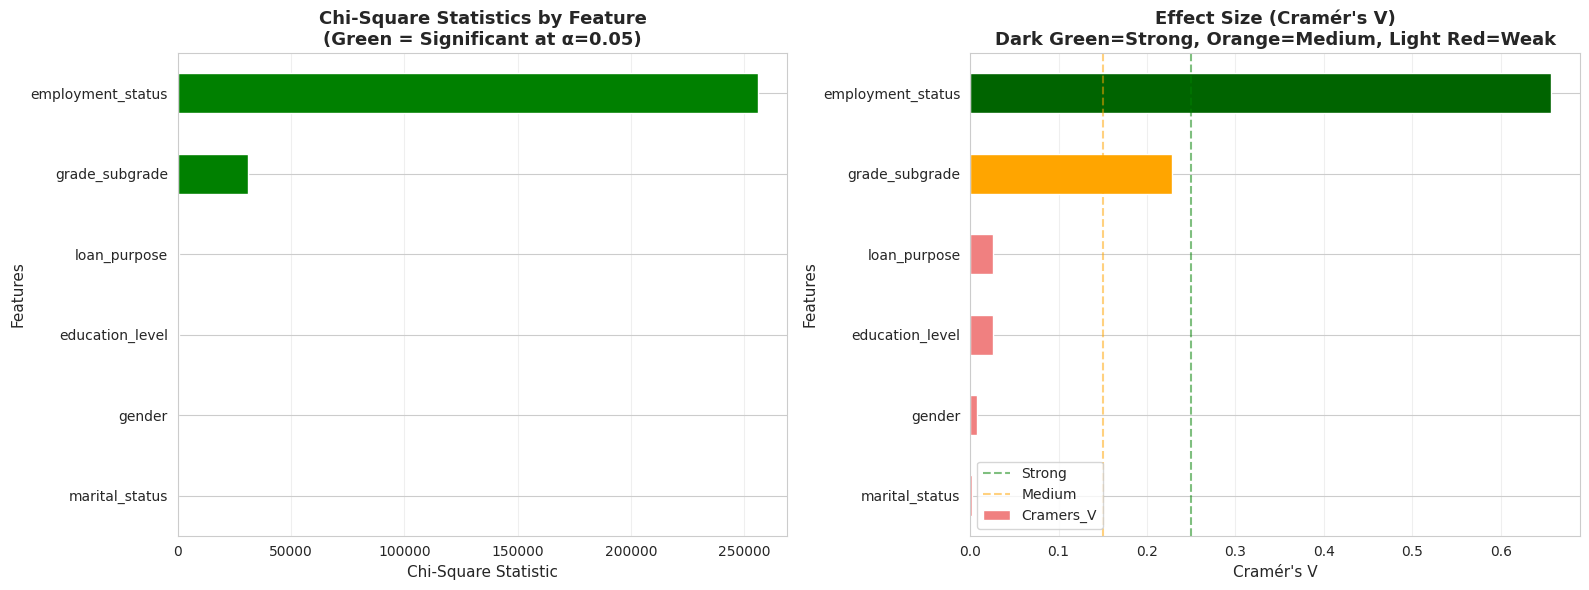


✓ Statistical testing complete


In [9]:
print("\n" + "="*80)
print("SECTION 7: CATEGORICAL FEATURES - STATISTICAL TESTS")
print("="*80)

categorical_features = [col for col in train_df.select_dtypes(include=['object']).columns 
                       if col != 'id']

if len(categorical_features) > 0:
    print("\n🔬 PERFORMING CHI-SQUARE TESTS (Feature vs Target):")
    print("-"*80)
    print("Testing independence between categorical features and target variable...")
    
    chi2_results = []
    
    for col in categorical_features:
        # Create contingency table
        contingency_table = pd.crosstab(train_df[col], train_df['loan_paid_back'])
        
        # Perform chi-square test
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        # Calculate Cramér's V (effect size)
        n = contingency_table.sum().sum()
        min_dim = min(contingency_table.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0
        
        chi2_results.append({
            'Feature': col,
            'Chi2_Statistic': chi2,
            'P_Value': p_value,
            'DOF': dof,
            'Cramers_V': cramers_v,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Effect_Size': 'Strong' if cramers_v > 0.25 else 'Medium' if cramers_v > 0.15 else 'Weak'
        })
    
    chi2_df = pd.DataFrame(chi2_results).sort_values('Chi2_Statistic', ascending=False)
    print("\n📊 Chi-Square Test Results:")
    print(chi2_df.to_string(index=False))
    
    # Summary
    significant_features = chi2_df[chi2_df['P_Value'] < 0.05]
    print(f"\n📈 SUMMARY:")
    print(f"  • Total features tested: {len(chi2_df)}")
    print(f"  • Significant associations (p < 0.05): {len(significant_features)}")
    print(f"  • Strong effect size (Cramér's V > 0.25): {len(chi2_df[chi2_df['Cramers_V'] > 0.25])}")
    print(f"  • Medium effect size (0.15 < V ≤ 0.25): {len(chi2_df[(chi2_df['Cramers_V'] > 0.15) & (chi2_df['Cramers_V'] <= 0.25)])}")
    print(f"  • Weak effect size (V ≤ 0.15): {len(chi2_df[chi2_df['Cramers_V'] <= 0.15])}")
    
    if len(significant_features) > 0:
        print(f"\n🎯 Most significant features (top 5):")
        for idx, row in significant_features.head(5).iterrows():
            print(f"  • {row['Feature']}: Chi2={row['Chi2_Statistic']:.2f}, p={row['P_Value']:.2e}, V={row['Cramers_V']:.3f}")
    
    # Visualize chi-square results
    print("\n📊 Generating chi-square visualization...")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Chi-square statistics
    ax1 = axes[0]
    chi2_df_sorted = chi2_df.sort_values('Chi2_Statistic', ascending=True)
    colors = ['green' if p < 0.05 else 'gray' for p in chi2_df_sorted['P_Value']]
    chi2_df_sorted.plot(x='Feature', y='Chi2_Statistic', kind='barh', ax=ax1, 
                        color=colors, legend=False)
    ax1.set_title('Chi-Square Statistics by Feature\n(Green = Significant at α=0.05)',
                 fontsize=13, fontweight='bold')
    ax1.set_xlabel('Chi-Square Statistic', fontsize=11)
    ax1.set_ylabel('Features', fontsize=11)
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. Effect sizes (Cramér's V)
    ax2 = axes[1]
    chi2_df_sorted = chi2_df.sort_values('Cramers_V', ascending=True)
    colors = ['darkgreen' if v > 0.25 else 'orange' if v > 0.15 else 'lightcoral' 
              for v in chi2_df_sorted['Cramers_V']]
    chi2_df_sorted.plot(x='Feature', y='Cramers_V', kind='barh', ax=ax2, 
                       color=colors, legend=False)
    ax2.set_title('Effect Size (Cramér\'s V)\nDark Green=Strong, Orange=Medium, Light Red=Weak',
                 fontsize=13, fontweight='bold')
    ax2.set_xlabel('Cramér\'s V', fontsize=11)
    ax2.set_ylabel('Features', fontsize=11)
    ax2.axvline(x=0.25, color='green', linestyle='--', alpha=0.5, label='Strong')
    ax2.axvline(x=0.15, color='orange', linestyle='--', alpha=0.5, label='Medium')
    ax2.legend()
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n⚠️ No categorical features found for chi-square testing")

print("\n✓ Statistical testing complete")

# 9: CORRELATION ANALYSIS


SECTION 8: CORRELATION ANALYSIS

🔗 Analyzing correlations for 6 numerical features...
--------------------------------------------------------------------------------

🎯 CORRELATION WITH TARGET (loan_paid):
--------------------------------------------------------------------------------
credit_score            0.235
annual_income           0.006
loan_amount            -0.004
interest_rate          -0.131
debt_to_income_ratio   -0.336

📊 CORRELATION STRENGTH SUMMARY:
  • Strong positive (r > 0.3): 0
  • Strong negative (r < -0.3): 1
    - debt_to_income_ratio: -0.336
  • Moderate positive (0.1 < r ≤ 0.3): 1
    - credit_score: 0.235
  • Moderate negative (-0.3 ≤ r < -0.1): 1
    - interest_rate: -0.131

--------------------------------------------------------------------------------
⚠️ MULTICOLLINEARITY CHECK:
--------------------------------------------------------------------------------
✓ No severe multicollinearity detected (all |r| ≤ 0.7)

📊 Generating correlation visualizations..

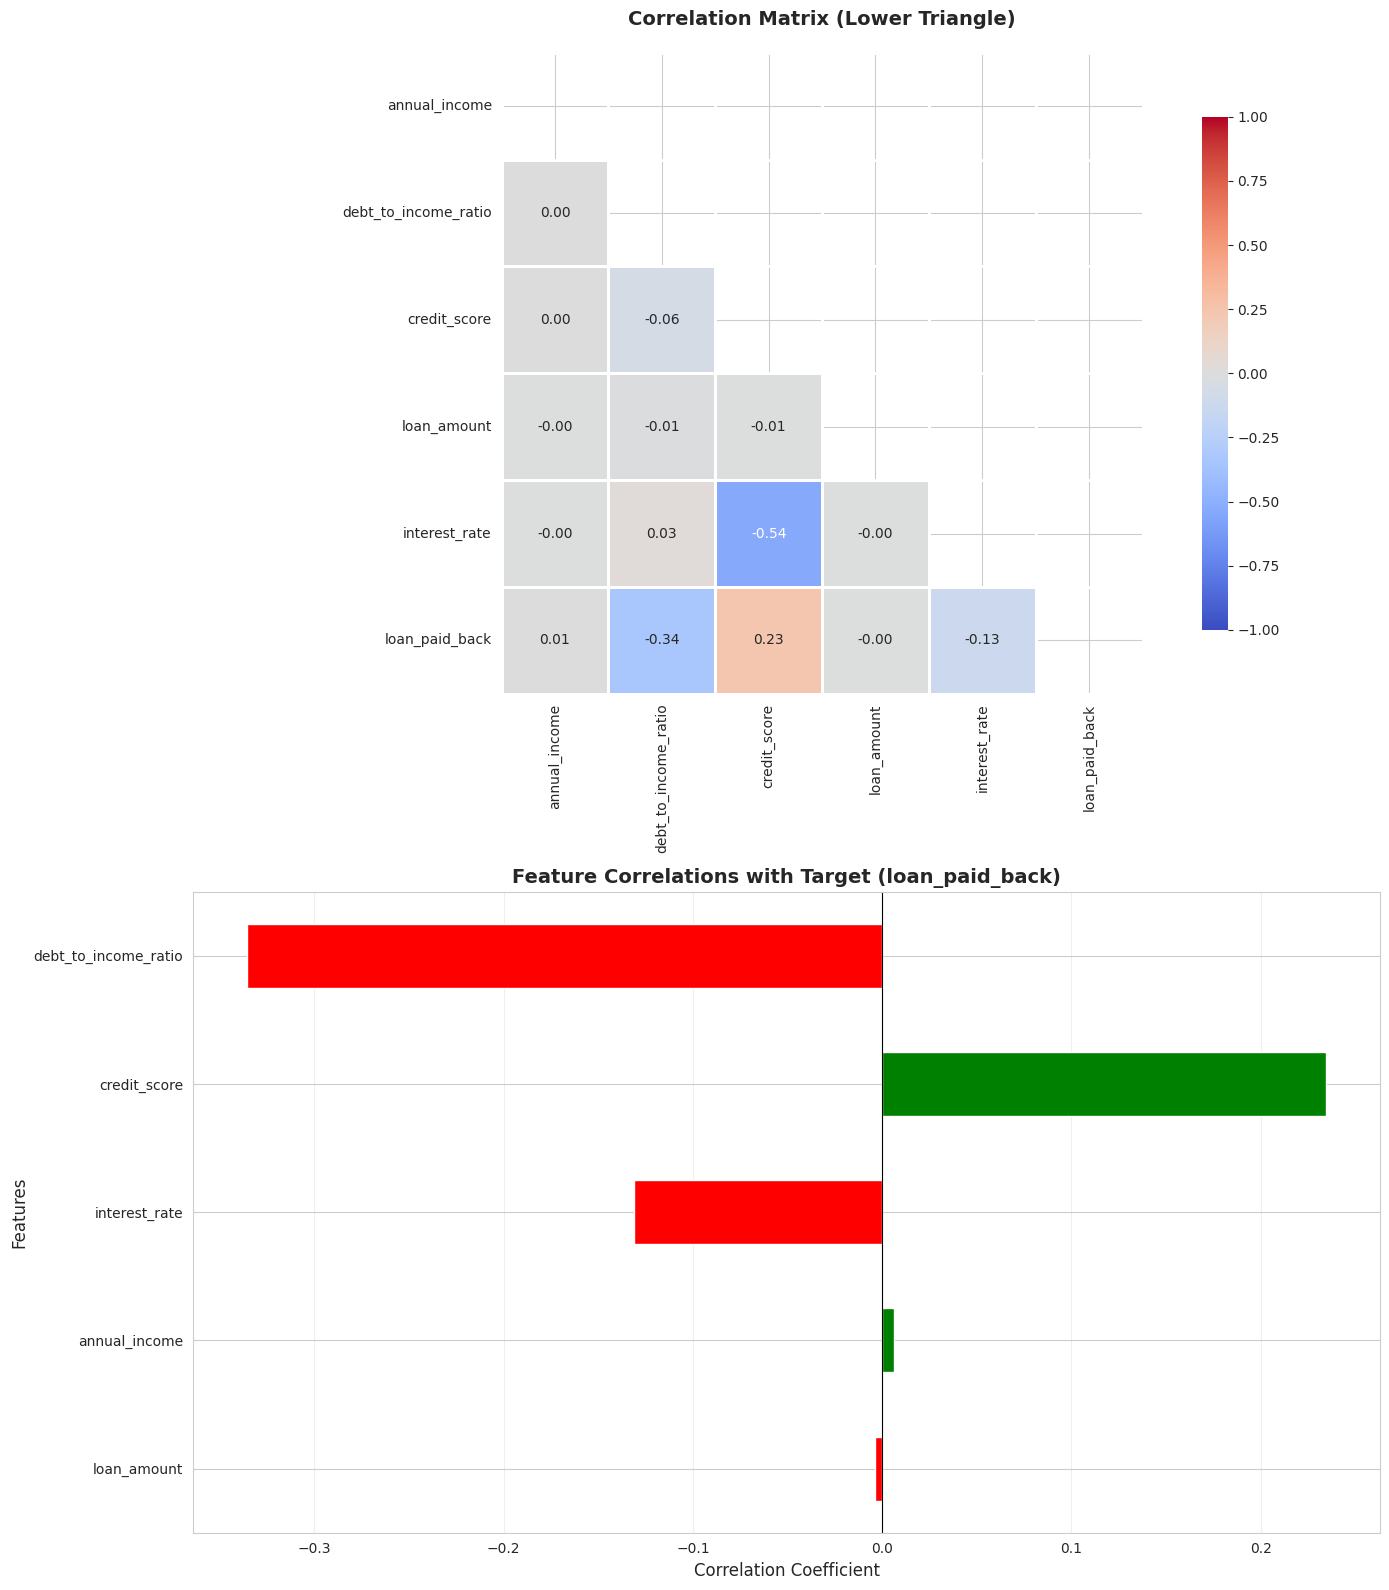


📊 Generating scatter plots for top correlated features...


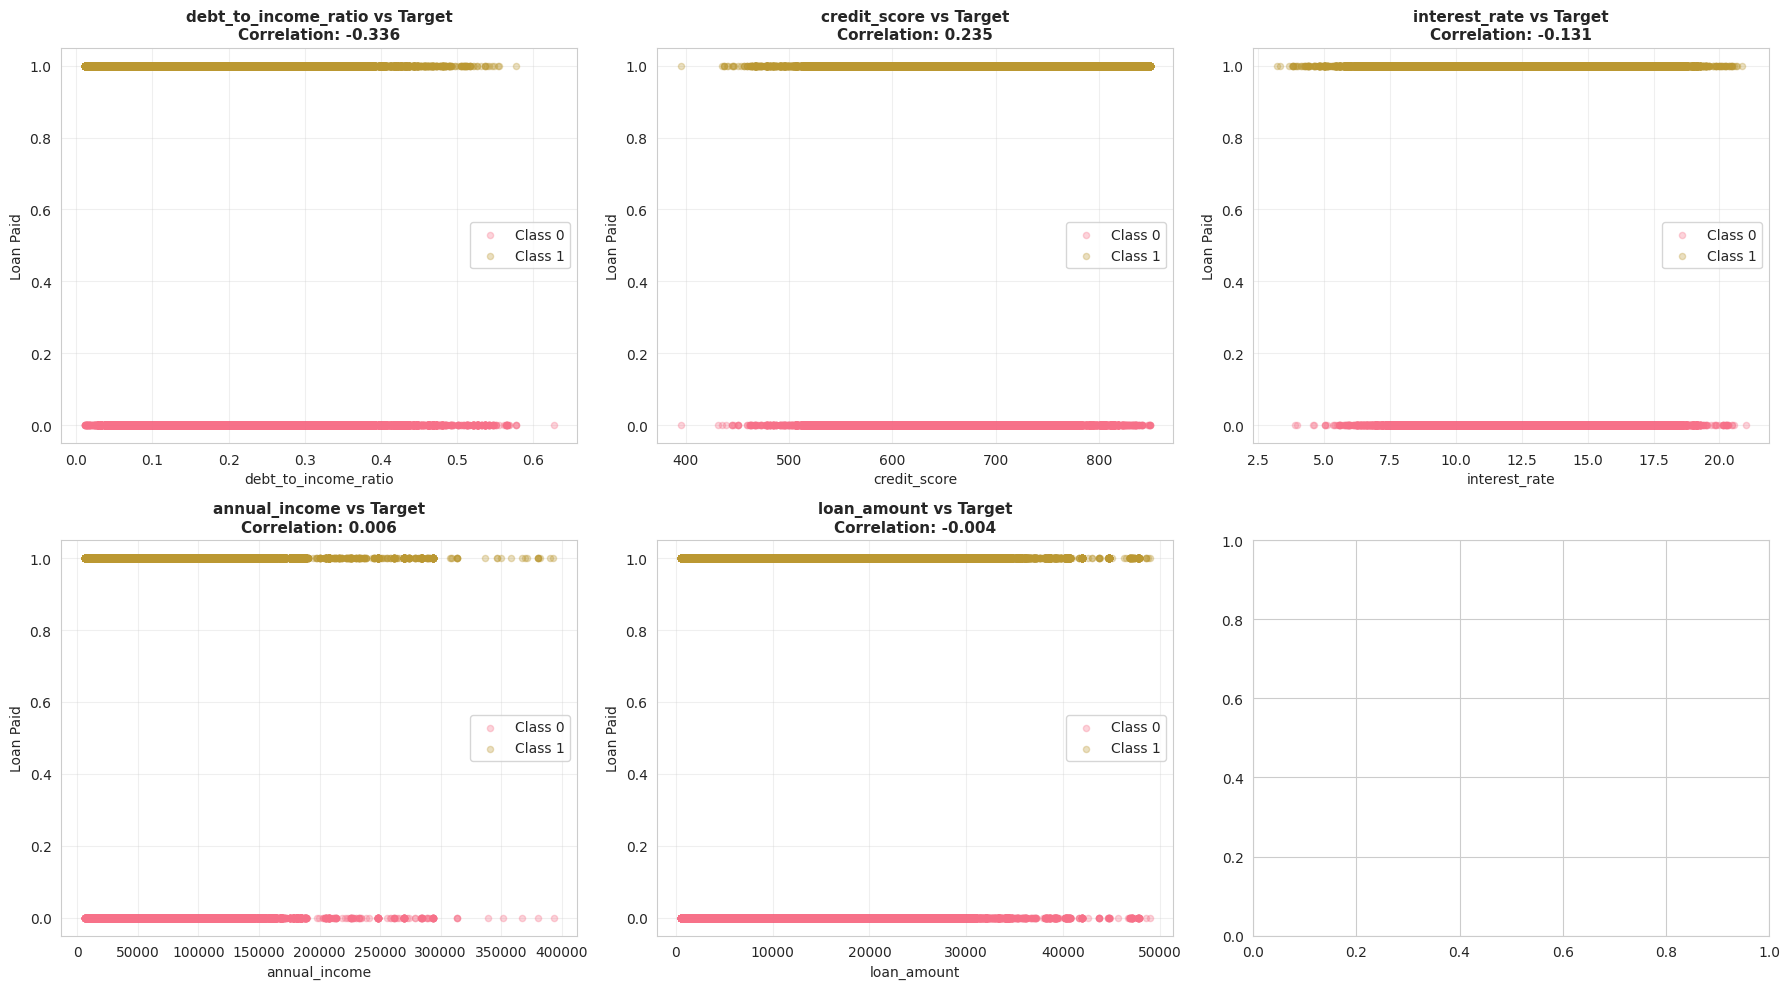


✓ Correlation analysis complete


In [10]:
print("\n" + "="*80)
print("SECTION 8: CORRELATION ANALYSIS")
print("="*80)

# Get numerical features
numerical_features = [col for col in train_df.select_dtypes(include=[np.number]).columns 
                     if col not in ['id']]

print(f"\n🔗 Analyzing correlations for {len(numerical_features)} numerical features...")
print("-"*80)

# Calculate correlation matrix
corr_matrix = train_df[numerical_features].corr()

# Correlation with target
if 'loan_paid_back' in numerical_features:
    target_corr = corr_matrix['loan_paid_back'].drop('loan_paid_back').sort_values(ascending=False)
    
    print("\n🎯 CORRELATION WITH TARGET (loan_paid):")
    print("-"*80)
    print(target_corr.to_string())
    
    # Identify strong correlations
    strong_positive = target_corr[target_corr > 0.3]
    strong_negative = target_corr[target_corr < -0.3]
    moderate_positive = target_corr[(target_corr > 0.1) & (target_corr <= 0.3)]
    moderate_negative = target_corr[(target_corr < -0.1) & (target_corr >= -0.3)]
    
    print(f"\n📊 CORRELATION STRENGTH SUMMARY:")
    print(f"  • Strong positive (r > 0.3): {len(strong_positive)}")
    if len(strong_positive) > 0:
        for feat, corr_val in strong_positive.items():
            print(f"    - {feat}: {corr_val:.3f}")
    
    print(f"  • Strong negative (r < -0.3): {len(strong_negative)}")
    if len(strong_negative) > 0:
        for feat, corr_val in strong_negative.items():
            print(f"    - {feat}: {corr_val:.3f}")
    
    print(f"  • Moderate positive (0.1 < r ≤ 0.3): {len(moderate_positive)}")
    if len(moderate_positive) > 0 and len(moderate_positive) <= 5:
        for feat, corr_val in moderate_positive.items():
            print(f"    - {feat}: {corr_val:.3f}")
    
    print(f"  • Moderate negative (-0.3 ≤ r < -0.1): {len(moderate_negative)}")
    if len(moderate_negative) > 0 and len(moderate_negative) <= 5:
        for feat, corr_val in moderate_negative.items():
            print(f"    - {feat}: {corr_val:.3f}")

# Multicollinearity detection
print("\n" + "-"*80)
print("⚠️ MULTICOLLINEARITY CHECK:")
print("-"*80)

# Find highly correlated feature pairs (excluding target correlation)
high_corr_pairs = []
features_without_target = [col for col in numerical_features if col != 'loan_paid_back']

for i in range(len(features_without_target)):
    for j in range(i+1, len(features_without_target)):
        feat1 = features_without_target[i]
        feat2 = features_without_target[j]
        corr_val = corr_matrix.loc[feat1, feat2]
        
        if abs(corr_val) > 0.7:  # High correlation threshold
            high_corr_pairs.append({
                'Feature_1': feat1,
                'Feature_2': feat2,
                'Correlation': corr_val,
                'Abs_Correlation': abs(corr_val)
            })

if len(high_corr_pairs) > 0:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Abs_Correlation', ascending=False)
    print(f"\n⚠️ Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.7):")
    print(high_corr_df.to_string(index=False))
    print("\n💡 Recommendation: Consider removing one feature from each highly correlated pair")
else:
    print("✓ No severe multicollinearity detected (all |r| ≤ 0.7)")

# Visualizations
print("\n📊 Generating correlation visualizations...")

# 1. Full correlation heatmap
fig, axes = plt.subplots(2, 1, figsize=(14, 16))

ax1 = axes[0]
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax1, vmin=-1, vmax=1)
ax1.set_title('Correlation Matrix (Lower Triangle)', fontsize=14, fontweight='bold', pad=20)

# 2. Target correlation bar plot
if 'loan_paid_back' in numerical_features:
    ax2 = axes[1]
    target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=True).index)
    colors = ['green' if x > 0 else 'red' for x in target_corr_sorted]
    target_corr_sorted.plot(kind='barh', ax=ax2, color=colors)
    ax2.set_title('Feature Correlations with Target (loan_paid_back)', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Correlation Coefficient', fontsize=12)
    ax2.set_ylabel('Features', fontsize=12)
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Top correlated features scatter plots
if 'loan_paid_back' in numerical_features and len(target_corr) > 0:
    print("\n📊 Generating scatter plots for top correlated features...")
    
    # Get top 6 features by absolute correlation
    top_features = target_corr.abs().sort_values(ascending=False).head(6).index.tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, feat in enumerate(top_features):
        ax = axes[idx]
        
        # Scatter plot with regression line
        for target_val in [0, 1]:
            data = train_df[train_df['loan_paid_back'] == target_val]
            ax.scatter(data[feat], data['loan_paid_back'], 
                      alpha=0.3, label=f'Class {target_val}',
                      s=20)
        
        ax.set_title(f'{feat} vs Target\nCorrelation: {target_corr[feat]:.3f}',
                    fontsize=11, fontweight='bold')
        ax.set_xlabel(feat, fontsize=10)
        ax.set_ylabel('Loan Paid', fontsize=10)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n✓ Correlation analysis complete")

# 10: FEATURE IMPORTANCE ANALYSIS (BASIC)


SECTION 9: FEATURE IMPORTANCE ANALYSIS

🌲 Training Random Forest for feature importance...
--------------------------------------------------------------------------------
Training Random Forest classifier...

📊 FEATURE IMPORTANCE RANKINGS:
--------------------------------------------------------------------------------
             Feature  Importance
   employment_status       0.734
debt_to_income_ratio       0.159
        credit_score       0.053
      grade_subgrade       0.037
       interest_rate       0.008
         loan_amount       0.003
       annual_income       0.003
     education_level       0.001
        loan_purpose       0.001
      marital_status       0.000
              gender       0.000

📈 IMPORTANCE STATISTICS:
  • Mean importance: 0.0909
  • Median importance: 0.0035
  • Std deviation: 0.2184
  • Top feature: employment_status (0.7339)

🎯 Features above average importance: 2
   Threshold: 0.0909

📊 CUMULATIVE IMPORTANCE:
  • Features for 80% importance: 1
  • F

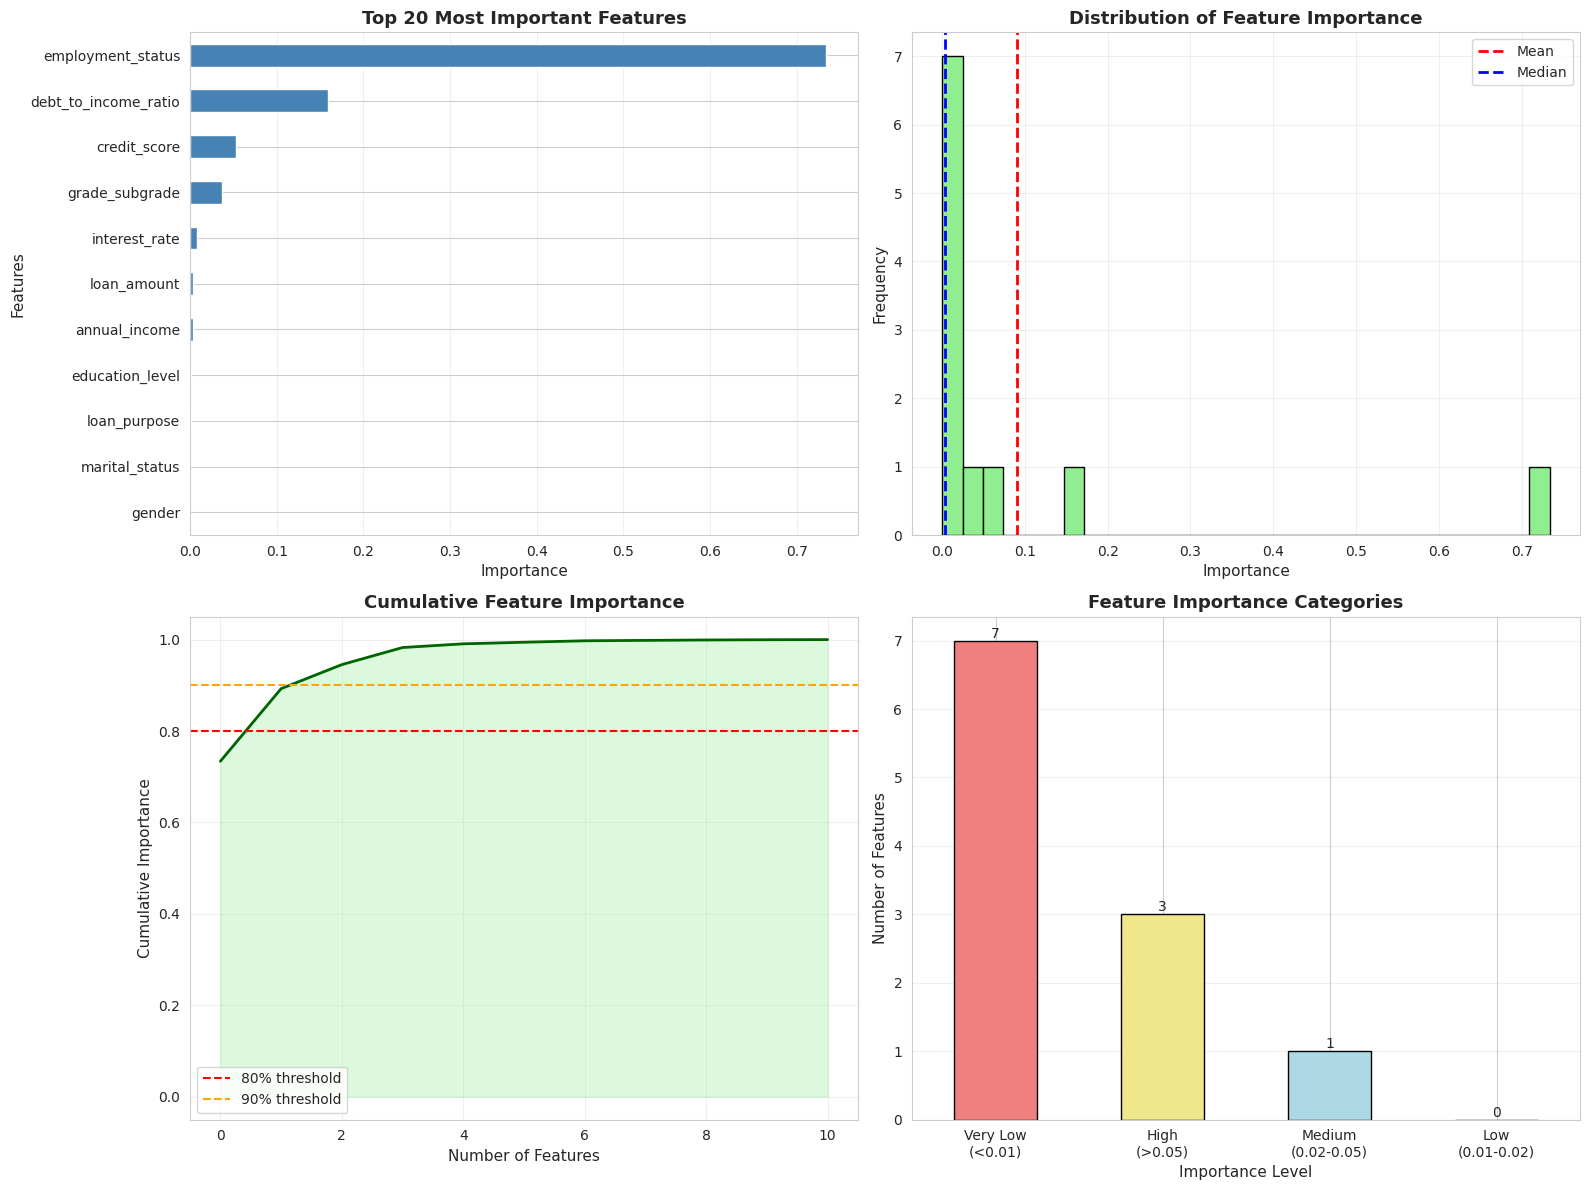


✓ Feature importance analysis complete


In [11]:
print("\n" + "="*80)
print("SECTION 9: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

print("\n🌲 Training Random Forest for feature importance...")
print("-"*80)

# Prepare data
X = train_df.drop(['loan_paid_back', 'id'], axis=1, errors='ignore')
y = train_df['loan_paid_back']

# Encode categorical variables
X_encoded = X.copy()
label_encoders = {}

categorical_cols = X_encoded.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

# Handle any remaining missing values
X_encoded = X_encoded.fillna(X_encoded.median())

# Train Random Forest
print("Training Random Forest classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_model.fit(X_encoded, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 FEATURE IMPORTANCE RANKINGS:")
print("-"*80)
print(feature_importance.to_string(index=False))

# Summary statistics
print("\n📈 IMPORTANCE STATISTICS:")
print(f"  • Mean importance: {feature_importance['Importance'].mean():.4f}")
print(f"  • Median importance: {feature_importance['Importance'].median():.4f}")
print(f"  • Std deviation: {feature_importance['Importance'].std():.4f}")
print(f"  • Top feature: {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance']:.4f})")

# Identify important features
threshold = feature_importance['Importance'].mean()
important_features = feature_importance[feature_importance['Importance'] > threshold]
print(f"\n🎯 Features above average importance: {len(important_features)}")
print(f"   Threshold: {threshold:.4f}")

# Cumulative importance
feature_importance['Cumulative_Importance'] = feature_importance['Importance'].cumsum()
features_for_80pct = len(feature_importance[feature_importance['Cumulative_Importance'] <= 0.8])
features_for_90pct = len(feature_importance[feature_importance['Cumulative_Importance'] <= 0.9])

print(f"\n📊 CUMULATIVE IMPORTANCE:")
print(f"  • Features for 80% importance: {features_for_80pct}")
print(f"  • Features for 90% importance: {features_for_90pct}")
print(f"  • Total features: {len(feature_importance)}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Top 20 features
ax1 = axes[0, 0]
top_20 = feature_importance.head(20)
top_20.sort_values('Importance').plot(x='Feature', y='Importance', kind='barh', 
                                       ax=ax1, color='steelblue', legend=False)
ax1.set_title('Top 20 Most Important Features', fontsize=13, fontweight='bold')
ax1.set_xlabel('Importance', fontsize=11)
ax1.set_ylabel('Features', fontsize=11)
ax1.grid(axis='x', alpha=0.3)

# 2. Importance distribution
ax2 = axes[0, 1]
feature_importance['Importance'].hist(bins=30, ax=ax2, color='lightgreen', edgecolor='black')
ax2.axvline(feature_importance['Importance'].mean(), color='red', 
            linestyle='--', linewidth=2, label='Mean')
ax2.axvline(feature_importance['Importance'].median(), color='blue', 
            linestyle='--', linewidth=2, label='Median')
ax2.set_title('Distribution of Feature Importance', fontsize=13, fontweight='bold')
ax2.set_xlabel('Importance', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Cumulative importance
ax3 = axes[1, 0]
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
ax3.plot(range(len(feature_importance_sorted)), 
         feature_importance_sorted['Cumulative_Importance'], 
         linewidth=2, color='darkgreen')
ax3.axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
ax3.axhline(y=0.9, color='orange', linestyle='--', label='90% threshold')
ax3.fill_between(range(len(feature_importance_sorted)), 
                 feature_importance_sorted['Cumulative_Importance'], 
                 alpha=0.3, color='lightgreen')
ax3.set_title('Cumulative Feature Importance', fontsize=13, fontweight='bold')
ax3.set_xlabel('Number of Features', fontsize=11)
ax3.set_ylabel('Cumulative Importance', fontsize=11)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Feature importance categories
ax4 = axes[1, 1]
importance_categories = pd.cut(feature_importance['Importance'], 
                               bins=[0, 0.01, 0.02, 0.05, 1.0],
                               labels=['Very Low\n(<0.01)', 'Low\n(0.01-0.02)', 
                                      'Medium\n(0.02-0.05)', 'High\n(>0.05)'])
category_counts = importance_categories.value_counts()
colors = ['lightcoral', 'khaki', 'lightblue', 'lightgreen']
category_counts.plot(kind='bar', ax=ax4, color=colors, edgecolor='black')
ax4.set_title('Feature Importance Categories', fontsize=13, fontweight='bold')
ax4.set_xlabel('Importance Level', fontsize=11)
ax4.set_ylabel('Number of Features', fontsize=11)
ax4.grid(axis='y', alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

# Add value labels on bars
for container in ax4.containers:
    ax4.bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete")

# Reference
##### I have intermediate knowledge of Stats and EDA, for help i have used AI.